In [116]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import math
from scipy.stats import iqr
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy import stats

In [117]:
## Features

def mean(x):
    """Calculates mean"""
    mean_x = np.mean(x)
    return mean_x

def std_dev(x):
    """Calculates standard deviation"""
    std_x = np.std(x)
    return std_x
    
def mad(x):
    """Calculates median absolute deviation"""
    mad_x = np.median(np.abs(x - np.median(x)))
    return mad_x

def minimum(x):
    """Calculates minimum"""
    return min(x)

def maximum(x):
    """Calculates maximum"""
    return max(x)

def energy_measure(x):
    """Calculates energy measures"""
    em_x = np.mean(np.square(x))
    return em_x

def inter_quartile_range(x):
    """Calculates inter-quartile range"""
    iqr_x = np.subtract(*np.percentile(x, [75, 25]))
    return iqr_x

def sma(x, y, z):
    """Calculates signal magnitude area"""   
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    abs_z = np.absolute(z)
    return np.mean(abs_x+abs_y+abs_z)

def skewness(x):
    """Calculates skewness"""
    skew_x=stats.skew(x)
    return skew_x

def kurt(x):
    """Calculates kurtosis"""
    kurt_x = stats.kurtosis(x,fisher=False)
    return kurt_x
    
def max_index(x):
    """Calculates index of maximum"""
    idx_x = np.argmax(x)
    return idx_x

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [118]:
acc_cols = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'std_acc_z', 'mad_acc_x', 'min_acc_x', 'min_acc_y',
            'max_acc_x', 'max_acc_y', 'max_acc_z', 'em_acc_x', 'em_acc_y', 'em_acc_z', 'sma_acc']

def process_acc(input_df, columns, output_df):
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        mean_acc_x = mean(x)
        mean_acc_y = mean(y)
        mean_acc_z = mean(z)
        std_acc_z = std_dev(z)
        mad_acc_x = mad(x)
        min_acc_x = min(x)
        min_acc_y = min(y)
        max_acc_x = max(x)
        max_acc_y = max(y)
        max_acc_z = max(z)
        em_acc_x = energy_measure(x)
        em_acc_y = energy_measure(y)
        em_acc_z = energy_measure(z)
        sma_acc = sma(x, y, z)
        
        acc_data = [mean_acc_x, mean_acc_y, mean_acc_z, std_acc_z, mad_acc_x, min_acc_x, min_acc_y, max_acc_x,
                    max_acc_y, max_acc_z, em_acc_x, em_acc_y, em_acc_z, sma_acc]
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [119]:
macc_cols = ['mean_macc', 'std_macc', 'mad_macc', 'max_macc', 'em_macc', 'iqr_macc', 'sma_macc', 'label']

def process_mag_acc(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[6][i]]
        l = input_df[5][i]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        mean_macc = mean(x)
        std_macc = std_dev(x)
        mad_macc = mad(x)
        max_macc = max(x)
        em_macc = energy_measure(x)
        iqr_macc = inter_quartile_range(x)
        sma_macc = np.mean(np.absolute(x))
        l = l  
        
        macc_data = [mean_macc, std_macc, mad_macc, max_macc, em_macc, iqr_macc, sma_macc, l]
        output_df = output_df.append(pd.Series(macc_data, index=columns), ignore_index=True)

    return output_df

In [120]:
maccj_cols = ['mean_macc_jerk', 'min_macc_jerk', 'iqr_macc_jerk', 'sma_macc_jerk']
def process_mag_acc_jerk(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[6][i]]
        l = input_df[5][i]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        mean_macc_jerk = mean(x)
        min_macc_jerk = min(x)
        iqr_macc_jerk = inter_quartile_range(x)
        sma_macc_jerk = np.mean(np.absolute(x))
        
        maccj_data = [mean_macc_jerk, min_macc_jerk, iqr_macc_jerk, sma_macc_jerk]
        output_df = output_df.append(pd.Series(maccj_data, index=columns), ignore_index=True)

    return output_df

In [121]:
accj_cols = ['std_accj_z', 'mad_accj_x', 'iqr_accj_y']
def process_acc_jerk(input_df, columns, output_df):
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        std_accj_z = std_dev(z)
        mad_accj_x = mad(x)
        iqr_accj_y = inter_quartile_range(y)
        
        accj_data = [std_accj_z, mad_accj_x, iqr_accj_y]
        
        output_df = output_df.append(pd.Series(accj_data, index=columns), ignore_index=True)

    return output_df

In [122]:
facc_jerk_cols = ['mean_faccj_y','mad_facc_y', 'min_facc_y', 'max_facc_y', 'max_facc_z', 'em_facc_y', 'iqr_facc_y'] 

def process_facc_jerk(input_df, columns, output_df):

    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]

        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        mean_faccj_y = mean(y)
        mad_facc_y = mad(y)
        min_facc_y = min(y)
        max_facc_y = max(y)
        max_facc_z = max(z)
        em_facc_y = energy_measure(y)
        iqr_facc_y = inter_quartile_range(y)
        
        acc_data = [mean_faccj_y, mad_facc_y, min_facc_y, max_facc_y, max_facc_z, em_facc_y, iqr_facc_y]
#         acc_data = [mean(y)+mad(y)+minimum(y)+maximum(y)+maximum(z)+energy_measure(y)+iqr(y)]
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [123]:
facc_mag_cols = ['skew_mfacc']

def process_facc_mag(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[6][i]]
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        label = (input_df[5][1], )

        skew = stats.skew(x)
        acc_data = [skew]
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [124]:
facc_jmag_cols = ['mean_mfacc_jerk', 'mad_mfacc_jerk', 'max_mfacc_jerk']

def process_faccj_mag(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()

    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[6][i]]
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        label = (input_df[5][1], )

        mean = np.mean(x)
        mad = np.median(np.abs(x - np.median(x)))
        maximum = np.max(x)

        acc_data = [mean, mad, maximum]
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [125]:
def hist_activities(df):
    df['label'].value_counts().plot(kind='bar', title='Training examples by activity type')
    plt.show()
    
def plot_activity(activity, df):
    data = df[df.iloc[:, 5] == activity][[1, 2, 3]][:2000]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_act_signals(df):
    plot_activity("sitting", df)
    plt.ylabel('sitting')
    plt.show()
    plot_activity("walking", df)
    plt.ylabel('walking')
    plt.show()
    plot_activity("standing", df)
    plt.ylabel('standing')
    plt.show()
    plot_activity("laying_down", df)
    plt.ylabel('laying_down')
    plt.show()

In [126]:
def calc_jerk(acc, ts):
    jk = [0]* len(acc)
    for i in range(1,len(acc)):
        jk[i-1] = 1000*(acc[i] - acc[i-1])/(ts[i] - ts[i-1])
    return jk

def fmagnitude(num):
    return math.sqrt(num.real**2 + num.imag**2)

In [127]:
def get_session_dirs(path):
    path = path
    dirs = []
    dir_list = [x[0] for x in os.walk(path)]
    last_dirs = ["1_android.sensor.accelerometer.data.csv.gz","4_android.sensor.gyroscope.data.csv.gz"]
    dirs = []
    for each_dir in dir_list[2:]:

        if "data" in each_dir:
            dirs.append(each_dir)

    dirs.sort(key=lambda x:x[-22:])
    return dirs

In [128]:
def get_jerk(df):
    df[1] = calc_jerk(df[1],df[0])
    df[2] = calc_jerk(df[2],df[0])
    df[3] = calc_jerk(df[3],df[0])
    return df

def get_fft(df):
    df[1] = np.fft.fft(df[1])
    df[2] = np.fft.fft(df[2])
    df[3] = np.fft.fft(df[3])
    df[1] = [fmagnitude(j) for j in df[1]]
    df[2] = [fmagnitude(j) for j in df[2]]
    df[3] = [fmagnitude(j) for j in df[3]]
    return df

def five_point_smoothing(df):
    m=np.array(df[1])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[1] = m_smooth
        
    m=np.array(df[2])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[2] = m_smooth
    
    m = np.array(df[3])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[3] = m_smooth
    
    return df

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [129]:
def process_csv_data(path):
    dirs = get_session_dirs(path)
    out_acc_df = pd.DataFrame(columns=acc_cols)
    acc_mag = pd.DataFrame(columns = macc_cols)
    acc_jerk_mag = pd.DataFrame(columns = maccj_cols)
    out_acc_jerk_df = pd.DataFrame(columns=accj_cols)
    out_facc_df = pd.DataFrame(columns=facc_jerk_cols)
    facc_mag = pd.DataFrame(columns = facc_mag_cols)
    facc_jerk_mag = pd.DataFrame(columns = facc_jmag_cols)

    acc_gy_df = pd.DataFrame()

    for i in dirs: 
        full_path_acc = os.path.normpath(i + "/" + "1_android.sensor.accelerometer.data.csv")
        full_path_gy = os.path.normpath(i + "/" + "4_android.sensor.gyroscope.data.csv")

        print("processing acceleration: " + full_path_acc)
        in_df_ac = pd.read_csv(full_path_acc, sep=',', header=None)

        #cropping
        if in_df_ac.shape[0] > 3000:
    
            in_df_ac = in_df_ac.drop(list(range(1000)), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])
            in_df_ac = in_df_ac.drop(list(range(in_df_ac.shape[0]-1000, in_df_ac.shape[0])), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])
            
        #smoothing
        in_df_ac = five_point_smoothing(in_df_ac)
    
        #jerk
        in_df_ac_jerk = in_df_ac.copy()
        in_df_ac_jerk = get_jerk(in_df_ac_jerk)
        
        #fft
        in_df_fac = in_df_ac.copy()
        in_df_fac = get_fft(in_df_fac)
        
        #fft_jerk
        in_df_fac_jerk = in_df_ac_jerk.copy()
        in_df_fac_jerk = get_fft(in_df_fac_jerk)

        out_acc_df = process_acc(in_df_ac, acc_cols, out_acc_df)
        acc_mag = process_mag_acc(in_df_ac, macc_cols, acc_mag)
        acc_jerk_mag = process_mag_acc_jerk(in_df_ac_jerk, maccj_cols, acc_jerk_mag)
        out_acc_jerk_df = process_acc_jerk(in_df_ac_jerk, accj_cols, out_acc_jerk_df)

        out_facc_df = process_facc_jerk(in_df_fac, facc_jerk_cols, out_facc_df)
        facc_mag = process_facc_mag(in_df_fac, facc_mag_cols, facc_mag)
        facc_jerk_mag = process_faccj_mag(in_df_fac_jerk, facc_jmag_cols, facc_jerk_mag)

        acc_gy_df = pd.concat([out_acc_df, acc_jerk_mag, out_acc_jerk_df, out_facc_df, facc_mag,
                               facc_jerk_mag, acc_mag], axis=1)

    print(acc_gy_df.shape)
    return acc_gy_df

In [131]:
training_set_df = process_csv_data("Sessions2/")

processing acceleration: Sessions2/14442D57F7E1B88_Tue_Mar_06_18-33_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: Sessions2/14442D57F7E1B88_Wed_Mar_07_11-53_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: Sessions2/14442D57F7E1B88_Wed_Mar_07_13-36_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: Sessions2/14442D57F7E1B88_Wed_Mar_07_13-42_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: Sessions2/14442D57F7E1B88_Wed_Mar_07_13-44_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: Sessions2/14442D57F7E1B88_Wed_Mar_07_13-57_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: Sessions2/14442D57F7E1B88_Thu_Feb_08_00-16_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: Sessions2/14442D57F7E1B88_Thu_Feb_08_00-18_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration:

In [132]:
training_set_df.to_csv("5sec_smooth_cropped_38_best_feat.csv")

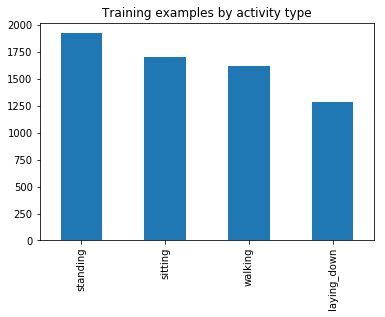

,mean_acc_x,mean_acc_y,mean_acc_z,std_acc_z,mad_acc_x,min_acc_x,min_acc_y,max_acc_x,max_acc_y,max_acc_z,...,mad_mfacc_jerk,max_mfacc_jerk,mean_macc,std_macc,mad_macc,max_macc,em_macc,iqr_macc,sma_macc,label
2677,-7.306681,-5.041681,-3.438924,1.188156,0.359402,-8.663217,-6.458314,-5.863435,-3.343933,-1.143027,...,739.527625,6721.818680,9.621653,0.445483,0.276843,10.965629,92.774670,0.571069,9.621653,standing
6269,-10.229064,-2.215279,-2.085353,1.436651,1.241069,-14.337386,-6.279648,-6.068363,1.455355,1.439073,...,1150.965160,11234.604765,10.808780,1.917120,1.377253,14.745244,120.505078,2.683927,10.808780,walking
2189,-9.812102,-2.537959,-0.347552,2.716028,1.890153,-16.692073,-8.452953,-3.428866,5.664625,10.514980,...,2183.622481,22944.284047,10.651299,2.802070,2.161835,18.261006,121.301774,4.281109,10.651299,walking
217,-4.437263,-5.790062,6.343617,0.045742,0.009576,-4.481017,-5.882972,-4.405072,-5.719842,6.417716,...,703.875195,6805.119615,9.667453,0.010459,0.006857,9.702374,93.459754,0.013682,9.667453,laying_down
4996,4.916110,-4.323243,7.360863,0.071294,0.023759,4.803733,-4.535711,5.031931,-4.141761,7.533468,...,16220.497362,158849.050481,9.852025,0.030365,0.020006,9.954637,97.063314,0.039623,9.852025,standing


In [133]:
hist_activities(training_set_df)
# plot_act_signals(in_df_ac)

training_set_df = clean_dataset(training_set_df)

combined_training_df = training_set_df
combined_training_df = combined_training_df.iloc[np.random.permutation(len(combined_training_df))]
combined_training_df.head()

In [134]:
## Training set

feat_list = [acc_cols, macc_cols, accj_cols, facc_jerk_cols, facc_mag_cols, facc_jmag_cols, maccj_cols]

training_data = combined_training_df[acc_cols+accj_cols+facc_jerk_cols+facc_mag_cols+facc_jmag_cols+maccj_cols+macc_cols].as_matrix()
training_targets = training_data[:, -1]
training_data = training_data[:, :-1]

print(macc_cols)

std_scale = preprocessing.StandardScaler().fit(training_data)
training_data_std = std_scale.transform(training_data)

print(len(training_data_std), len(training_data_std[0]))
print(len(training_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
training_targets.reshape(len(training_targets))
print(training_targets)
print(training_targets.shape)

training_bin_targets = []
for i in training_targets:
    training_bin_targets.append(cache[i])
print(len(training_bin_targets))

training_bin_targets[: 5]

['mean_macc', 'std_macc', 'mad_macc', 'max_macc', 'em_macc', 'iqr_macc', 'sma_macc', 'label']
6543 39
6543
['standing' 'walking' 'walking' ..., 'standing' 'walking' 'standing']
(6543,)
6543


/Users/gringotts/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[3, 2, 2, 0, 3]

In [ ]:
## Testing set
testing_set_df = process_cs v_data('aashna/')

processing acceleration: aashna/14442D57F7E1B88_Thu_Mar_08_11-35_2018_PST/data/1_android.sensor.accelerometer.data.csv
processing acceleration: aashna/14442D57F7E1B88_Fri_Mar_09_21-47_2018_PST/data/1_android.sensor.accelerometer.data.csv


In [ ]:
training_set_df.to_csv("5sec_smooth_cropped_38_best_feat_test.csv")

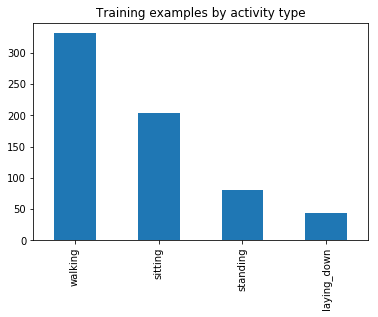

,mean_macc_jerk,std_macc_jerk,mad_macc_jerk,min_macc_jerk,max_macc_jerk,em_macc_jerk,iqr_macc_jerk,sma_macc_jerk,mean_mfacc,std_mfacc,...,idx_mfacc_jerk,mean_macc,std_macc,mad_macc,min_macc,max_macc,em_macc,iqr_macc,sma_macc,label
407,128.366996,105.335361,41.561289,7.225362,1047.998134,27573.623791,87.316550,128.366996,44.881755,22.498141,...,308.0,9.849948,3.640074,2.728901,2.927559,20.963346,110.271610,5.554815,9.849948,walking
42,3.512197,2.821860,1.012785,0.245637,31.218146,20.298422,2.140498,3.512197,142.516693,72.015837,...,389.0,9.800841,0.029016,0.012976,9.676637,10.001254,96.057329,0.025999,9.800841,sitting
380,116.348717,99.040291,40.345865,6.440954,868.605909,23346.003253,88.318464,116.348717,125.041805,64.134897,...,2238.0,9.915416,3.354638,2.192097,3.755807,21.602743,109.569078,4.698948,9.915416,walking
94,11.620629,14.636616,3.475962,0.247574,130.904228,349.269555,9.982930,11.620629,102.282909,52.662015,...,1865.0,9.717132,0.144265,0.037208,9.076639,10.527947,94.443466,0.105105,9.717132,sitting
193,14.080500,224.727998,1.511098,0.266469,7873.046172,50700.933385,3.079548,14.080500,560.923089,238.795911,...,1974.0,9.771055,1.052296,0.027657,9.589006,45.789230,96.580845,0.055319,9.771055,sitting


In [145]:
hist_activities(testing_set_df)
# plot_act_signals(in_df_ac)
testing_set_df = clean_dataset(testing_set_df)
combined_testing_df = testing_set_df
combined_testing_df = combined_testing_df.iloc[np.random.permutation(len(combined_testing_df))]
combined_testing_df.head()

In [102]:
testing_data = combined_testing_df[acc_cols+macc_cols+accj_cols+facc_jerk_cols+facc_mag_cols+facc_jmag_cols+maccj_cols].as_matrix()
testing_targets = testing_data[:, -1]
testing_data = testing_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(testing_data)
testing_data_std = std_scale.transform(testing_data)

print(len(testing_data_std), len(testing_data_std[0]))
print(len(testing_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
testing_targets.reshape(len(testing_targets))
print(testing_targets.shape)

testing_bin_targets = []
for i in testing_targets:
    testing_bin_targets.append(cache[i])
print(len(testing_bin_targets))

testing_bin_targets[: 5]

NameError: name 'combined_testing_df' is not defined

In [169]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model = RandomForestClassifier()

# Training the model
model.fit(training_data, training_bin_targets)

# Testing on the testing data
predicted_values = model.predict(testing_data)

In [174]:
cvscore = cross_val_score(model, testing_data, testing_bin_targets, cv=10)
print(cvscore)
print(np.mean(cvscore))

[ 0.26020408  0.23469388  0.2627551   0.26342711  0.26598465  0.21227621
  0.20971867  0.20308483  0.29305913  0.2596401 ]
0.246484377254


In [171]:
acc_score = accuracy_score(testing_bin_targets, predicted_values)
print("Score: ", acc_score)

Score:  0.528787878788
